In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from collections import Counter
import scipy.signal as signal
from matplotlib.colors import ListedColormap
import re

import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components
import asrpy
%matplotlib inline

In [6]:
# scikit-learn (sklearn) が必要：LOF不良チャンネル検出で使用
import importlib.util
import sys
import subprocess

if importlib.util.find_spec("sklearn") is None:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scikit-learn"])

# データ読み込み

In [4]:
# BrainVisionファイルのパス
vhdr_path = "./data/raw/251224_HT/251224_HT_01.vhdr"   # vhdrヘッダ
# .vmrk と .eeg は .vhdr 内に記述されたパスが自動的に参照される

raw = mne.io.read_raw_brainvision(vhdr_path, preload=True)
display(raw.info)

Extracting parameters from ./data/raw/251224_HT/251224_HT_01.vhdr...
Setting channel info structure...
Reading 0 ... 1950829  =      0.000 ...  3901.658 secs...


/var/folders/19/kr4tj6fn79g5_pjmwz9v0zv00000gn/T/ipykernel_50793/2140364268.py:5: RuntimeWarning: No coordinate information found for channels ['33']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True)
/var/folders/19/kr4tj6fn79g5_pjmwz9v0zv00000gn/T/ipykernel_50793/2140364268.py:5: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True)
/var/folders/19/kr4tj6fn79g5_pjmwz9v0zv00000gn/T/ipykernel_50793/2140364268.py:5: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['33']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True)


<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, P3, P7, ...
 chs: 31 EEG, 1 misc
 custom_ref_applied: False
 dig: 34 items (3 Cardinal, 31 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: 2025-12-24 11:42:02 UTC
 nchan: 32
 projs: []
 sfreq: 500.0 Hz
>

# Rawデータ確認

In [7]:
# チャンネルリスト
print(raw.ch_names)
print(len(raw.ch_names))

['Fp1', 'Fz', 'F3', 'F7', 'FT9', 'FC5', 'FC1', 'C3', 'T7', 'TP9', 'CP5', 'CP1', 'P3', 'P7', 'O1', 'Oz', 'O2', 'P4', 'P8', 'TP10', 'CP6', 'CP2', 'Cz', 'C4', 'T8', 'FT10', 'FC6', 'FC2', 'F4', 'F8', 'Fp2', '33']
32


In [8]:
# 生データの読み直し
raw = mne.io.read_raw_brainvision(vhdr_path, preload=True)

# 電源ノイズ
raw.notch_filter(freqs=[50, 100], picks="eeg", method="fir")

# ダウンサンプリング
raw = raw.resample(sfreq=250)

Extracting parameters from ./data/raw/251224_HT/251224_HT_01.vhdr...
Setting channel info structure...
Reading 0 ... 1950829  =      0.000 ...  3901.658 secs...


/var/folders/19/kr4tj6fn79g5_pjmwz9v0zv00000gn/T/ipykernel_50793/1770269316.py:2: RuntimeWarning: No coordinate information found for channels ['33']. Setting channel types to misc. To avoid this warning, set channel types explicitly.
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True)
/var/folders/19/kr4tj6fn79g5_pjmwz9v0zv00000gn/T/ipykernel_50793/1770269316.py:2: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 s)



/var/folders/19/kr4tj6fn79g5_pjmwz9v0zv00000gn/T/ipykernel_50793/1770269316.py:2: RuntimeWarning: Not setting position of 1 misc channel found in montage:
['33']
Consider setting the channel types to be of EEG/sEEG/ECoG/DBS/fNIRS using inst.set_channel_types before calling inst.set_montage, or omit these channels when creating your montage.
  raw = mne.io.read_raw_brainvision(vhdr_path, preload=True)


Using matplotlib as 2D backend.


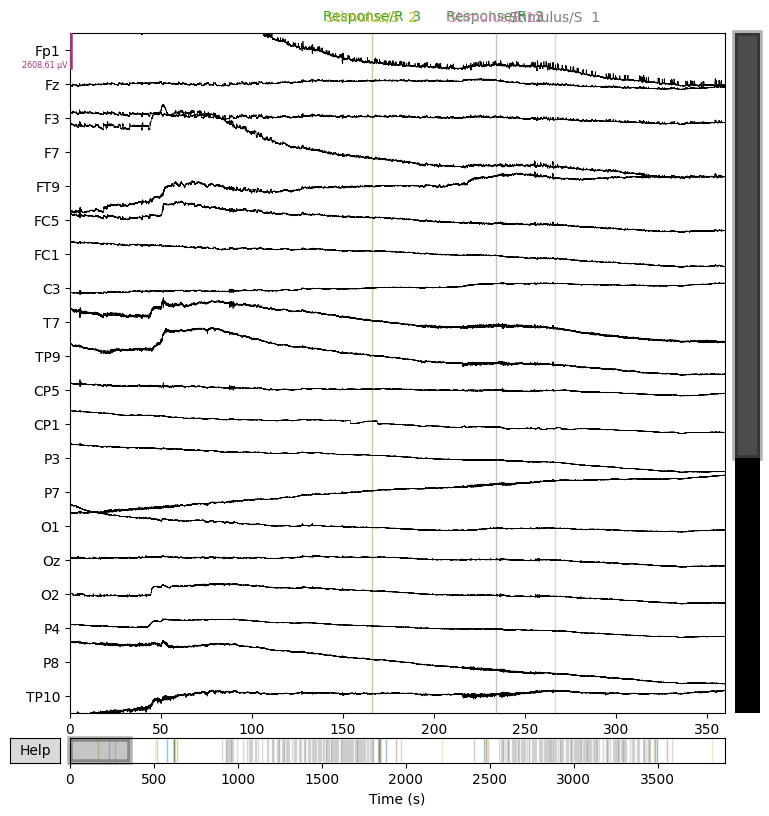

In [9]:
# 信号を可視化
raw.plot(scalings="auto", duration=360);  

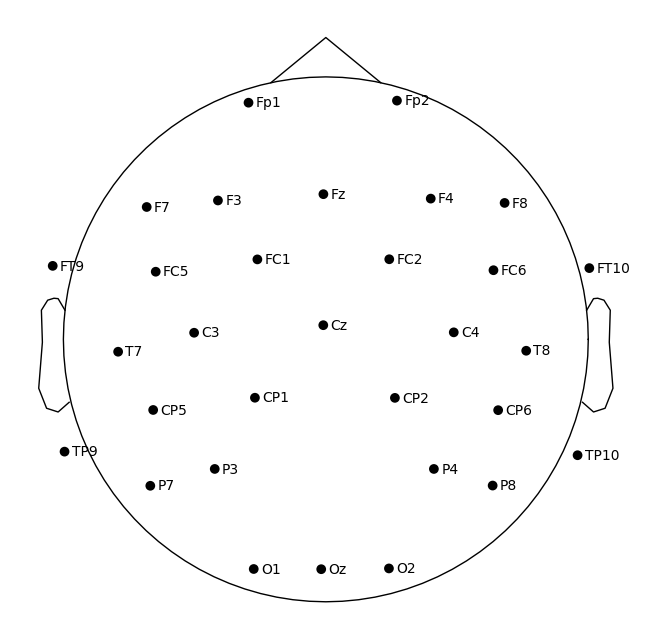

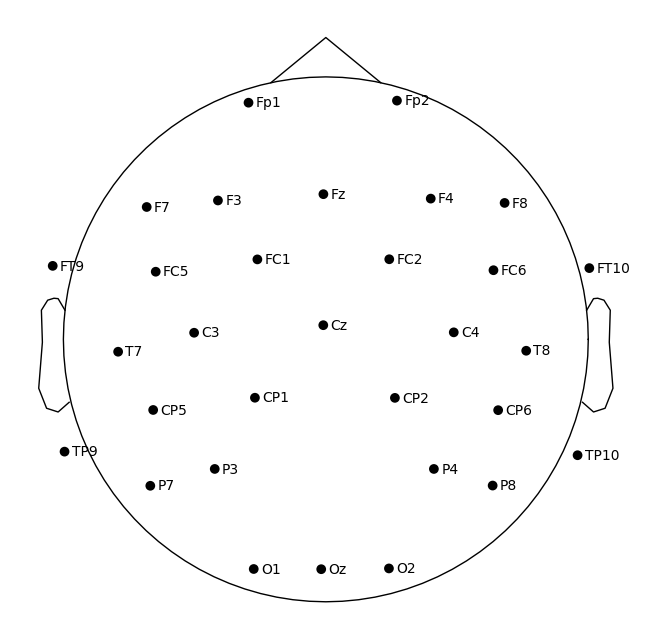

In [10]:
# モンタージュ配置
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)
raw.plot_sensors(ch_type = 'eeg', show_names=True, sphere=(0, 0.02, 0, 0.09))

Used Annotations descriptions: [np.str_('Response/R  1'), np.str_('Response/R  2'), np.str_('Response/R  3'), np.str_('Response/R  6'), np.str_('Response/R  7'), np.str_('Response/R 15'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15')]


/var/folders/19/kr4tj6fn79g5_pjmwz9v0zv00000gn/T/ipykernel_50793/3348078199.py:5: RuntimeWarning: More events than default colors available. You should pass a list of unique colors.
  mne.viz.plot_events(events, sfreq=raw.info["sfreq"], event_id=event_id)


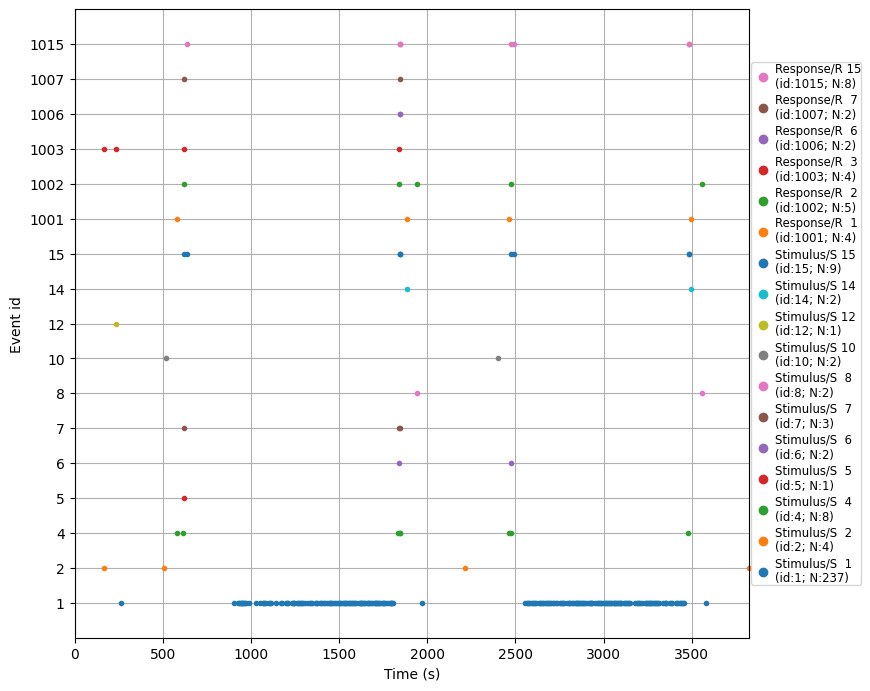

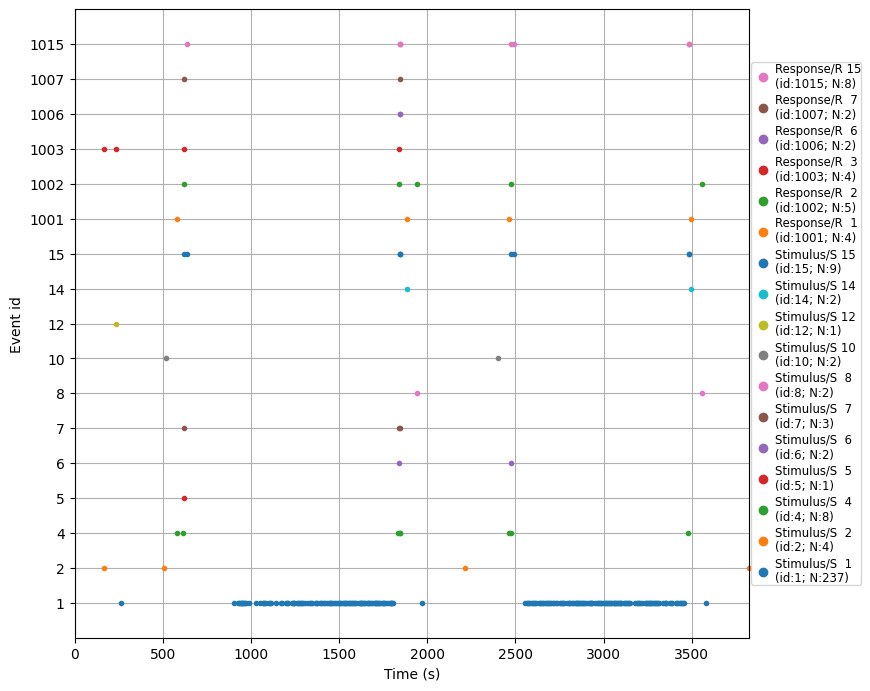

In [11]:
# イベント情報の可視化
events, event_id = mne.events_from_annotations(raw)

# イベントプロット
mne.viz.plot_events(events, sfreq=raw.info["sfreq"], event_id=event_id)

# trigger CSV と events の対応付け
`data/trigger/<被験者>/...csv` の `annotation` をEEG上のイベントに結びつけます。
CSV内の `trigger_value` は全て `1` なので、EEG側では基本的に `Stimulus/S  1` を対応先として使い、タイムスタンプずれはオフセット推定して補正します。

In [19]:
TRIG_PREFIX = "TRIG/"  # 追加する注釈にはprefixを付けて再実行時の重複を防ぐ

def _find_stimulus1_key(event_id: dict) -> str | None:
    # BrainVisionは 'Stimulus/S  1' のように空白が入ることがあるので両対応
    for k in event_id.keys():
        ks = str(k)
        if re.match(r"^Stimulus/S\s+1$", ks.strip()):
            return k
    for k in event_id.keys():
        if "Stimulus/S" in str(k) and str(k).strip().endswith("1"):
            return k
    return None

def _load_trigger_csv(csv_path: Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    required_cols = {"timestamp", "trigger_value", "annotation"}
    missing = required_cols - set(df.columns)
    if missing:
        raise ValueError(f"Trigger CSV missing columns: {missing} (found: {list(df.columns)})")
    df["timestamp"] = pd.to_datetime(df["timestamp"], errors="raise")
    df = df[df["trigger_value"] == 1].reset_index(drop=True)
    if len(df) == 0:
        raise ValueError(f"No trigger_value==1 rows in trigger CSV: {csv_path}")
    t0 = df.loc[0, "timestamp"]
    df["t_rel_s"] = (df["timestamp"] - t0).dt.total_seconds()
    return df

def _best_alignment_window(stim_times_s: np.ndarray, x_rel_s: np.ndarray, *, allow_linear: bool = True):
    """
    Find the best contiguous window in stim_times_s that matches x_rel_s (CSV relative time).
    We evaluate both constant-offset and (optionally) linear a+b*x fits and choose the best.

    Returns dict with keys: start, mode, a, b, cost, residuals, y_window.
    """
    stim_times_s = np.asarray(stim_times_s, dtype=float)
    x = np.asarray(x_rel_s, dtype=float)
    m = len(x)
    n = len(stim_times_s)
    if n < m:
        return None

    # robust cost: median absolute deviation (MAD)
    def mad(resid: np.ndarray) -> float:
        return float(np.median(np.abs(resid)))

    best = None
    for start in range(0, n - m + 1):
        y = stim_times_s[start : start + m]
        # constant offset (robust)
        offset = float(np.median(y - x))
        resid0 = y - (x + offset)
        cost0 = mad(resid0)
        cand = {
            "start": start,
            "mode": "offset",
            "a": offset,
            "b": 1.0,
            "cost": cost0,
            "residuals": resid0,
            "y_window": y,
        }

        # linear fit to absorb drift (optional)
        if allow_linear and m >= 3:
            b1, a1 = np.polyfit(x, y, 1)
            resid1 = y - (a1 + b1 * x)
            cost1 = mad(resid1)
            if cost1 < cand["cost"] * 0.9:
                cand = {
                    "start": start,
                    "mode": "linear",
                    "a": float(a1),
                    "b": float(b1),
                    "cost": cost1,
                    "residuals": resid1,
                    "y_window": y,
                }

        if best is None or cand["cost"] < best["cost"]:
            best = cand
    return best

def _remove_existing_trigger_annotations(raw: mne.io.BaseRaw, *, base_labels: list[str]):
    """Remove previously added trigger annotations to make the cell idempotent."""
    ann = raw.annotations
    if len(ann) == 0:
        return

    desc = np.asarray(ann.description, dtype=object)
    base = set(base_labels)
    mask_keep = []
    for d in desc:
        ds = str(d)
        if ds in base:
            mask_keep.append(False)
        elif ds.startswith(TRIG_PREFIX) or ds.startswith("TRIGGER/") or ds.startswith("TRIG:"):
            mask_keep.append(False)
        else:
            mask_keep.append(True)
    if not all(mask_keep):
        raw.set_annotations(ann[np.asarray(mask_keep, dtype=bool)])

In [20]:
# (2/4) trigger対応付け：入力（被験者・EEG側Stimulus/S 1抽出）
subject_id = Path(vhdr_path).parent.name
trigger_dir = Path("./data/trigger") / subject_id
csv_paths = sorted(trigger_dir.glob("*_actichamp_trigger_session.csv"))
if not csv_paths:
    raise FileNotFoundError(f"No trigger CSV found under: {trigger_dir}")

events_all, event_id_all = mne.events_from_annotations(raw)
stim1_key = _find_stimulus1_key(event_id_all)
sfreq = raw.info["sfreq"]

if stim1_key is None:
    print("[WARN] EEG側に 'Stimulus/S 1' が見つかりません。trigger対応付けをスキップします。")
else:
    stim_code = event_id_all[stim1_key]
    stim_events_all = events_all[events_all[:, 2] == stim_code]
    stim_times_s_all = stim_events_all[:, 0] / sfreq
    print(f"EEG Stimulus/S 1 count: {len(stim_times_s_all)}")

Used Annotations descriptions: [np.str_('Response/R  1'), np.str_('Response/R  2'), np.str_('Response/R  3'), np.str_('Response/R  6'), np.str_('Response/R  7'), np.str_('Response/R 15'), np.str_('Stimulus/S  1'), np.str_('Stimulus/S  2'), np.str_('Stimulus/S  4'), np.str_('Stimulus/S  5'), np.str_('Stimulus/S  6'), np.str_('Stimulus/S  7'), np.str_('Stimulus/S  8'), np.str_('Stimulus/S 10'), np.str_('Stimulus/S 12'), np.str_('Stimulus/S 14'), np.str_('Stimulus/S 15'), np.str_('TRIG/Feedback_High'), np.str_('TRIG/Feedback_Low'), np.str_('TRIG/Session_Start'), np.str_('TRIG/Session_Stop')]
EEG Stimulus/S 1 count: 237


In [21]:
# (3/4) trigger対応付け：CSV選択 + 相対時間にもとづく区間探索
best_global = None
if stim1_key is not None:
    for p in csv_paths:
        df = _load_trigger_csv(p)
        x_all = df["t_rel_s"].to_numpy(dtype=float)
        best = _best_alignment_window(stim_times_s_all, x_all, allow_linear=True)
        if best is None:
            continue
        best = {**best, "csv_path": p, "df_trig": df}
        if best_global is None or best["cost"] < best_global["cost"]:
            best_global = best

    if best_global is None:
        raise ValueError("Could not align any trigger CSV to EEG Stimulus/S 1 events.")

    df_trig = best_global["df_trig"]
    csv_path = best_global["csv_path"]
    start = best_global["start"]
    mode = best_global["mode"]
    a_offset_s = best_global["a"]
    b_scale = best_global["b"]
    residual_s = best_global["residuals"]
    y = best_global["y_window"]
    x = df_trig["t_rel_s"].to_numpy(dtype=float)

    print(f"Trigger CSV: {csv_path}")
    print(f"Best window start index in EEG Stimulus/S 1: {start}")
    if mode == "linear":
        print(f"Using linear alignment: y = a + b*x (a={a_offset_s:.3f}s, b={b_scale:.9f}), MAD={best_global['cost']:.3f}s")
    else:
        print(f"Using constant offset alignment: offset={a_offset_s:.3f}s, MAD={best_global['cost']:.3f}s")
    print(f"Residual summary [s]: median={float(np.median(residual_s)):.3f}, p95={float(np.percentile(np.abs(residual_s),95)):.3f}")

Trigger CSV: data/trigger/251224_HT/20251224_122401_actichamp_trigger_session.csv
Best window start index in EEG Stimulus/S 1: 112
Using linear alignment: y = a + b*x (a=2556.277s, b=1.000004909), MAD=0.001s
Residual summary [s]: median=0.000, p95=0.003


In [22]:
# (4/4) trigger対応付け：annotation追加・対応表作成・trigger events生成
if stim1_key is not None:
    # EEG側の対応区間（CSV行数ぶん）
    stim_events = stim_events_all[start : start + len(df_trig)]

    # 追加前に、過去に追加したtrigger注釈を除去（再実行での重複防止）
    base_labels = sorted(df_trig["annotation"].astype(str).unique().tolist())
    _remove_existing_trigger_annotations(raw, base_labels=base_labels)

    # CSVのannotationを raw に追加（orig_timeを揃える）
    if mode == "linear":
        onsets_s = a_offset_s + b_scale * x
    else:
        onsets_s = x + a_offset_s

    pref_desc = (TRIG_PREFIX + df_trig["annotation"].astype(str)).to_list()
    new_ann = mne.Annotations(
        onset=onsets_s,
        duration=np.zeros_like(onsets_s, dtype=float),
        description=pref_desc,
        orig_time=raw.annotations.orig_time,
    )
    raw.set_annotations(raw.annotations + new_ann)

    # 対応表（events ⇔ CSV）
    link_df = pd.DataFrame({
        "event_sample": stim_events[:, 0],
        "event_time_s": y,
        "csv_timestamp": df_trig["timestamp"].astype(str).to_numpy(),
        "csv_annotation": df_trig["annotation"].astype(str).to_numpy(),
        "csv_rel_s": x,
        "pred_time_s": onsets_s,
        "residual_s": residual_s,
    })
    display(link_df.head(10))

    # 追加したtrigger annotationだけをevents化（prefixで限定）
    labels_pref = sorted(set(pref_desc))
    regexp = "^(" + "|".join(re.escape(s) for s in labels_pref) + ")$"
    events_trig, event_id_trig = mne.events_from_annotations(raw, regexp=regexp)
    print("event_id_trig:", event_id_trig)
    print("n_trigger_events:", len(events_trig), "(expected:", len(df_trig), ")")

event_sample  event_time_s               csv_timestamp csv_annotation  \
0        639070      2556.280  2025-12-24 12:24:39.006222  Session_Start   
1        641606      2566.424  2025-12-24 12:24:49.155010  Feedback_High   
2        642860      2571.440  2025-12-24 12:24:54.170140  Feedback_High   
3        644112      2576.448  2025-12-24 12:24:59.179212  Feedback_High   
4        645364      2581.456  2025-12-24 12:25:04.184211   Feedback_Low   
5        647869      2591.476  2025-12-24 12:25:14.205610   Feedback_Low   
6        650371      2601.484  2025-12-24 12:25:24.213145  Feedback_High   
7        651620      2606.480  2025-12-24 12:25:29.210819  Feedback_High   
8        652869      2611.476  2025-12-24 12:25:34.205039  Feedback_High   
9        654120      2616.480  2025-12-24 12:25:39.208876  Feedback_High   

   csv_rel_s  pred_time_s  residual_s  
0   0.000000  2556.276673    0.003327  
1  10.148788  2566.425511   -0.001511  
2  15.163918  2571.440666   -0.000666  
3  20.172990  2576.449762   -0.001762  
4  25.177989  2581.454786    0.001214  
5  35.199388  2591.476234   -0.000234  
6  45.206923  2601.483818    0.000182  
7  50.204597  2606.481517   -0.001517  
8  55.198817  2611.475761    0.000239  
9  60.202654  2616.479623    0.000377

Used Annotations descriptions: [np.str_('TRIG/Feedback_High'), np.str_('TRIG/Feedback_Low'), np.str_('TRIG/Session_Start'), np.str_('TRIG/Session_Stop')]
event_id_trig: {np.str_('TRIG/Feedback_High'): 10001, np.str_('TRIG/Feedback_Low'): 10002, np.str_('TRIG/Session_Start'): 10003, np.str_('TRIG/Session_Stop'): 10004}
n_trigger_events: 124 (expected: 124 )


# セッション区間の切り出し（Session_Start〜Session_Stop）
`csv_annotation` の `Session_Start` と `Session_Stop` に対応するイベント（`TRIG/Session_Start`, `TRIG/Session_Stop`）から、各セッション区間を切り出します。
セッションは2つ存在する前提で、前後に 10〜20秒程度のバッファ（デフォルト15秒）を付けてcropする。

In [24]:
# (A) Session_Start/Stop をペアリングして、バッファ付き区間を作る
buffer_pre_s = 15.0   # 10〜20秒程度の範囲で調整可
buffer_post_s = 15.0  # 10〜20秒程度の範囲で調整可

start_label = f"{TRIG_PREFIX}Session_Start"
stop_label = f"{TRIG_PREFIX}Session_Stop"

def _pair_starts_stops(starts: np.ndarray, stops: np.ndarray):
    starts = np.sort(np.asarray(starts, dtype=float))
    stops = np.sort(np.asarray(stops, dtype=float))
    pairs_ = []
    j_ = 0
    for s_ in starts:
        while j_ < len(stops) and stops[j_] <= s_:
            j_ += 1
        if j_ >= len(stops):
            break
        pairs_.append((float(s_), float(stops[j_])))
        j_ += 1
    return pairs_

# まずは raw.annotations にある TRIG/Session_* から探す
ann = raw.annotations
descs = np.asarray(ann.description, dtype=object)
onsets = np.asarray(ann.onset, dtype=float)
pairs = _pair_starts_stops(onsets[descs == start_label], onsets[descs == stop_label])

# 2セッション取れない場合は、被験者フォルダ内の全CSVを個別にEEGへアラインして区間を作る
if len(pairs) < 2:
    print(f"[INFO] Found {len(pairs)} TRIG pairs in raw. Falling back to per-CSV alignment to recover 2 sessions.")

    # trigger CSV一覧を確実に取得
    subject_id = Path(vhdr_path).parent.name
    trigger_dir = Path("./data/trigger") / subject_id
    csv_paths = sorted(trigger_dir.glob("*_actichamp_trigger_session.csv"))
    if not csv_paths:
        raise FileNotFoundError(f"No trigger CSV found under: {trigger_dir}")

    # EEG側 Stimulus/S 1 時刻列を確実に用意（未実行の場合に備えて再計算）
    if "stim_times_s_all" not in globals():
        events_all, event_id_all = mne.events_from_annotations(raw)
        stim1_key = _find_stimulus1_key(event_id_all)
        if stim1_key is None:
            raise ValueError("EEG側に 'Stimulus/S 1' が見つからず、CSVアラインができません")
        stim_code = event_id_all[stim1_key]
        stim_events_all = events_all[events_all[:, 2] == stim_code]
        stim_times_s_all = stim_events_all[:, 0] / raw.info["sfreq"]

    pairs = []
    for p in csv_paths:
        df = _load_trigger_csv(p)
        ann_series = df["annotation"].astype(str)
        idx_start = ann_series[ann_series == "Session_Start"].index
        if len(idx_start) == 0:
            continue
        idx_start = int(idx_start[0])
        idx_stop = ann_series[(ann_series == "Session_Stop") & (ann_series.index > idx_start)].index
        if len(idx_stop) == 0:
            continue
        idx_stop = int(idx_stop[0])

        x_rel = df["t_rel_s"].to_numpy(dtype=float)
        best = _best_alignment_window(stim_times_s_all, x_rel, allow_linear=True)
        if best is None:
            continue
        a = float(best["a"])
        b = float(best["b"])
        t_start = a + b * float(df.loc[idx_start, "t_rel_s"])
        t_stop = a + b * float(df.loc[idx_stop, "t_rel_s"])
        pairs.append((t_start, t_stop))
        print(f"Aligned {p.name}: start={t_start:.3f}s stop={t_stop:.3f}s mode={best['mode']} MAD={best['cost']:.3f}s")

    pairs = sorted(pairs, key=lambda t: t[0])

if len(pairs) < 2:
    print(f"[WARN] Expected 2 sessions, but found {len(pairs)} pair(s): {pairs}")
else:
    print(f"Found {len(pairs)} session pair(s)")

recording_tmax = float(raw.times[-1])  # raw開始からの秒
session_windows = []
for k, (s, e) in enumerate(pairs, start=1):
    tmin = max(0.0, float(s) - buffer_pre_s)
    tmax = min(recording_tmax, float(e) + buffer_post_s)
    session_windows.append({
        "session": k,
        "start_s": float(s),
        "stop_s": float(e),
        "tmin_crop_s": float(tmin),
        "tmax_crop_s": float(tmax),
        "buffer_pre_s": float(buffer_pre_s),
        "buffer_post_s": float(buffer_post_s),
        "duration_core_s": float(e - s),
        "duration_with_buffer_s": float(tmax - tmin),
    })

session_windows_df = pd.DataFrame(session_windows)
display(session_windows_df)

[INFO] Found 1 TRIG pairs in raw. Falling back to per-CSV alignment to recover 2 sessions.
Aligned 20251224_115631_actichamp_trigger_session.csv: start=906.703s stop=1807.498s mode=linear MAD=0.001s
Aligned 20251224_122401_actichamp_trigger_session.csv: start=2556.277s stop=3457.073s mode=linear MAD=0.001s
Found 2 session pair(s)


session      start_s       stop_s  tmin_crop_s  tmax_crop_s  buffer_pre_s  \
0        1   906.703440  1807.498209   891.703440  1822.498209          15.0   
1        2  2556.276673  3457.072655  2541.276673  3472.072655          15.0   

   buffer_post_s  duration_core_s  duration_with_buffer_s  
0           15.0       900.794769              930.794769  
1           15.0       900.795981              930.795981

In [26]:
# (B) rawから区間を切り出す（このセクションでは切り出しのみ）
raw_full = raw  # 元の連続データ（以降も参照したい場合のため保持）
raw_sessions = []

for row in session_windows:
    tmin = row["tmin_crop_s"]
    tmax = row["tmax_crop_s"]
    sess_raw = raw_full.copy().crop(tmin=tmin, tmax=tmax)
    raw_sessions.append(sess_raw)

if len(raw_sessions) != 2:
    raise ValueError(f"Expected 2 session segments, but got {len(raw_sessions)}")

print("cropped sessions:", len(raw_sessions))
for i, r in enumerate(raw_sessions, start=1):
    print(f"  session{i}: tmin={r.times[0]:.3f}s, tmax={r.times[-1]:.3f}s, duration={r.times[-1]-r.times[0]:.3f}s")

cropped sessions: 2
  session1: tmin=0.000s, tmax=930.796s, duration=930.796s
  session2: tmin=0.000s, tmax=930.796s, duration=930.796s


# 前処理

--- session1 (origin) ---


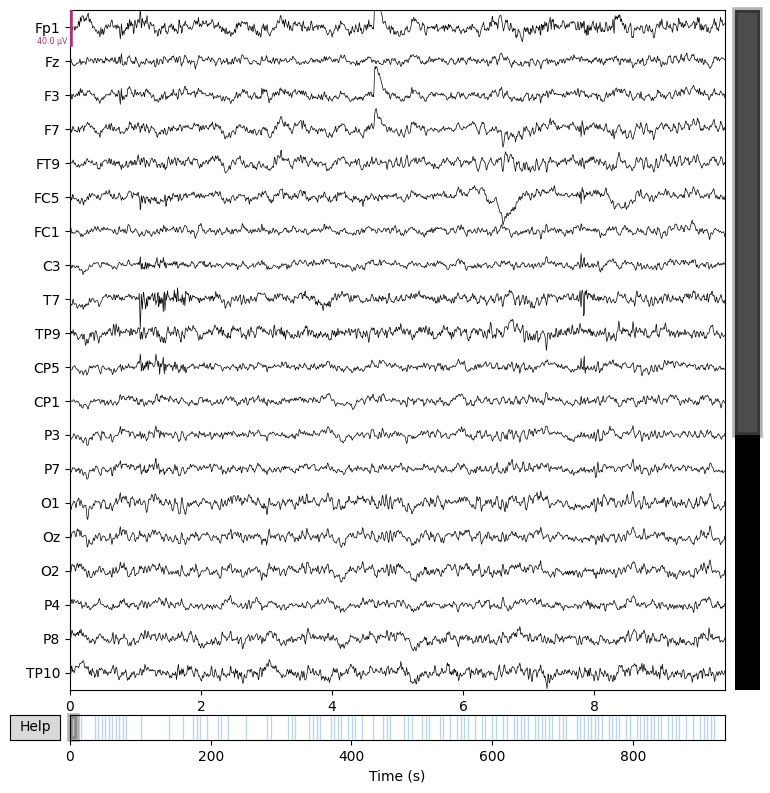

--- session2 (origin) ---


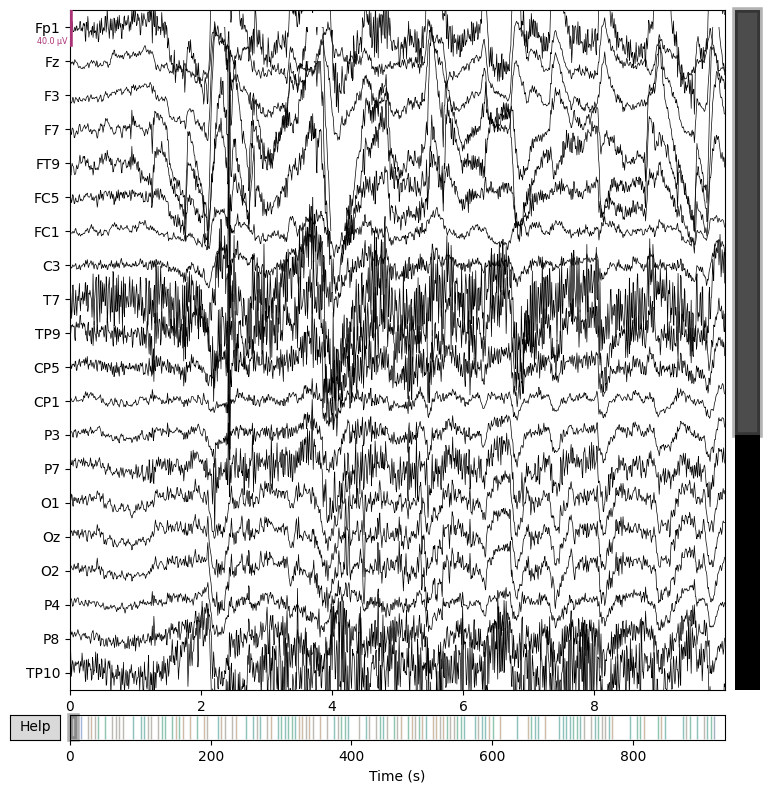

In [38]:
# セッション区間ごとのrawを保持（以降は2区間前提）
raw_sessions_origin = [r.copy() for r in raw_sessions]

# session1/2 を両方確認
for i, r in enumerate(raw_sessions, start=1):
    print(f"--- session{i} (origin) ---")
    r.plot(duration=10, start=0, scalings={"eeg": 20e-6})

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)

Effective window size : 8.192 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition 

/Users/yuto_matsuzawa/Desktop/EEG_Analize/.venv/lib/python3.13/site-packages/mne/viz/utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


--- session1 (after bandpass) ---


/Users/yuto_matsuzawa/Desktop/EEG_Analize/.venv/lib/python3.13/site-packages/mne/viz/utils.py:160: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


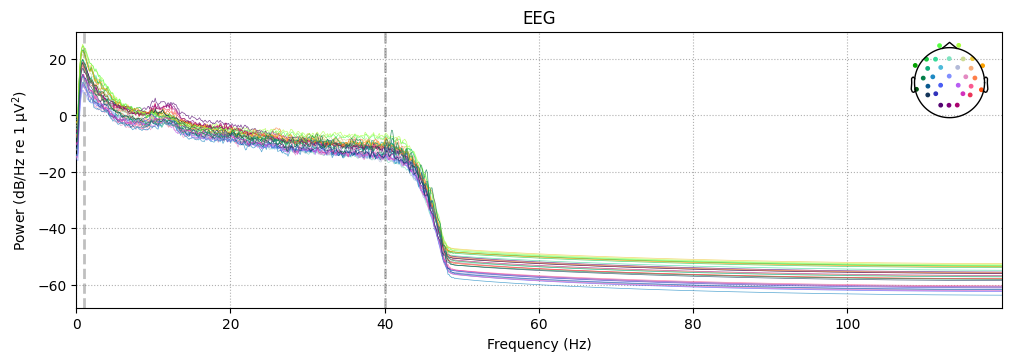

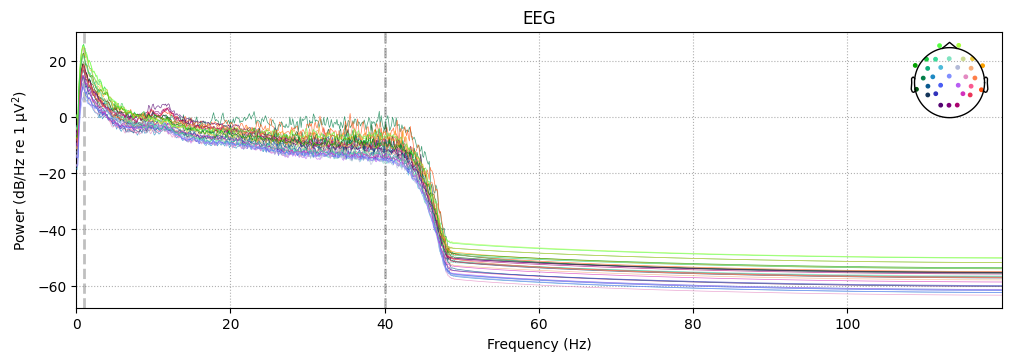

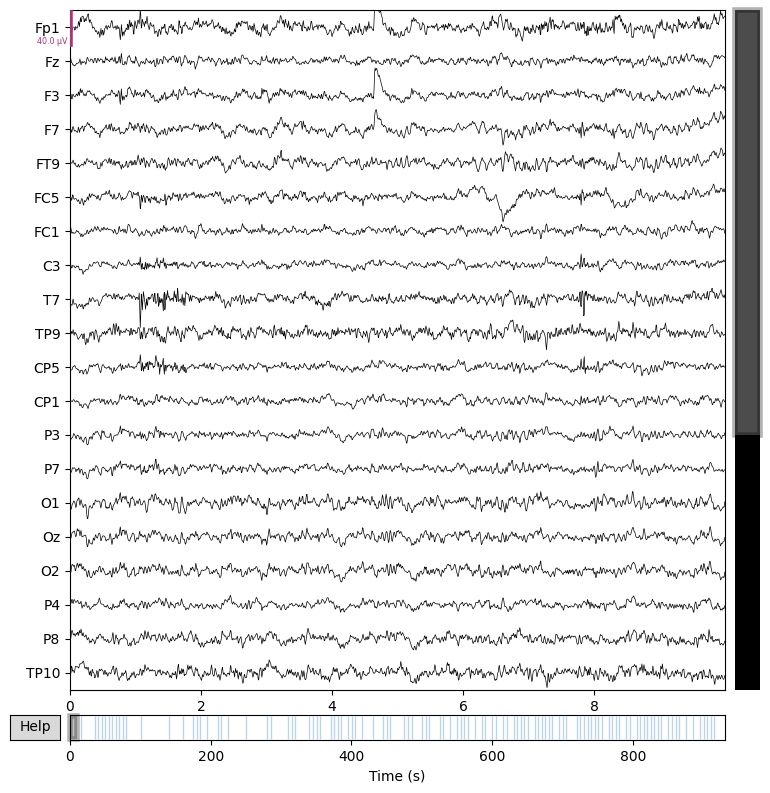

--- session2 (after bandpass) ---


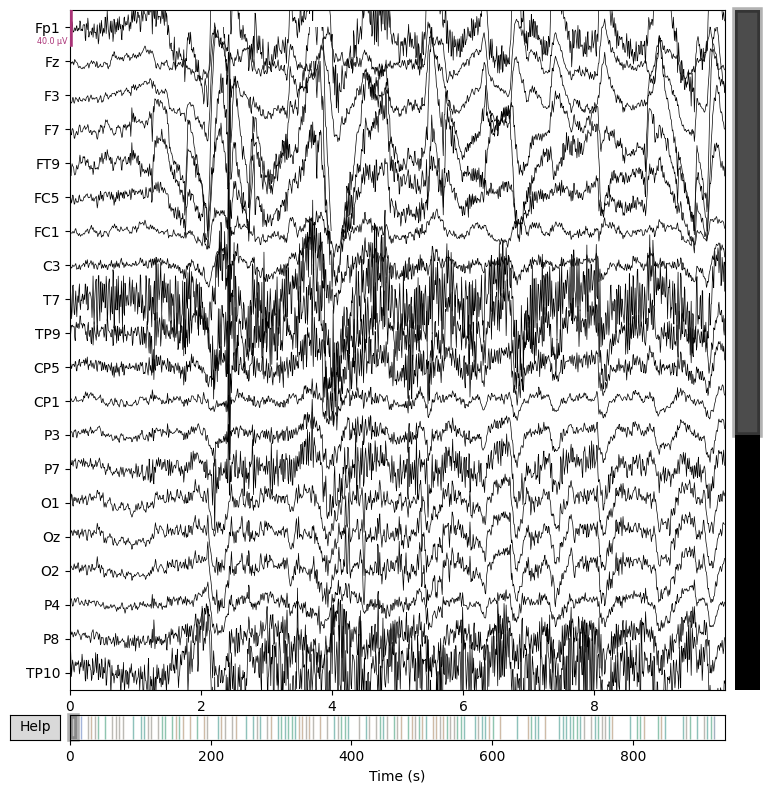

In [39]:
# バンドパスフィルタリング（セッション区間ごと）
for i, r in enumerate(raw_sessions, start=1):
    raw_sessions[i-1] = r.filter(l_freq=1, h_freq=40, picks="eeg")
    raw_sessions[i-1].compute_psd(fmax=120).plot();

# session1/2 を両方確認
for i, r in enumerate(raw_sessions, start=1):
    print(f"--- session{i} (after bandpass) ---")
    r.plot(duration=10, start=0, scalings={"eeg": 20e-6})

LOF: Detected bad channel(s): []
session1 bad_channel: 0
Setting channel interpolation method to {'eeg': 'spline'}.
LOF: Detected bad channel(s): ['Fp1']
session2 bad_channel: 1
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 96.2 mm
Computing interpolation matrix from 30 sensor positions
Interpolating 1 sensors
--- session1 (after LOF+interp) ---


/var/folders/19/kr4tj6fn79g5_pjmwz9v0zv00000gn/T/ipykernel_50793/2073035564.py:9: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  r.interpolate_bads(reset_bads=True, mode="accurate")


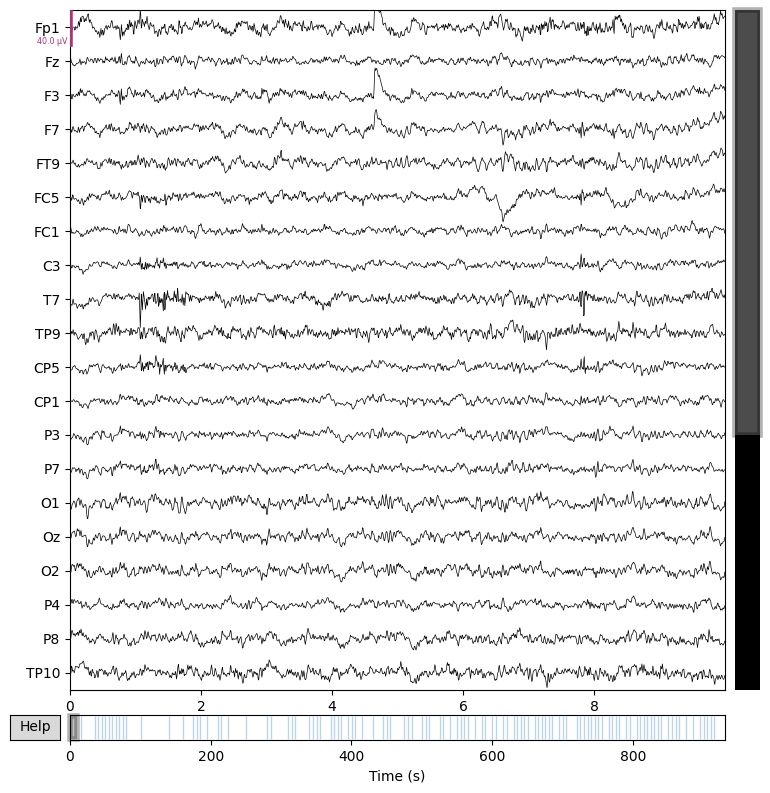

--- session2 (after LOF+interp) ---


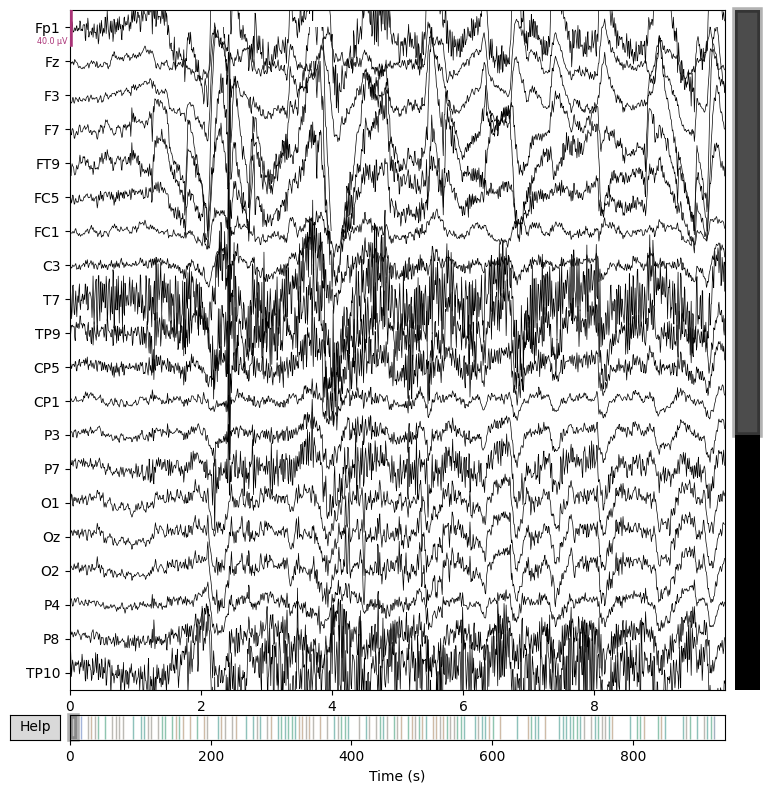

In [40]:
# 自動不良チャネル検出 (LOF)（セッション区間ごと）
for i, r in enumerate(raw_sessions, start=1):
    bad_chs = mne.preprocessing.find_bad_channels_lof(
        r, picks="eeg", n_neighbors=20, threshold=1.5, return_scores=False
    )
    print(f"session{i} bad_channel:", len(bad_chs))

    r.info["bads"] = bad_chs
    r.interpolate_bads(reset_bads=True, mode="accurate")
    raw_sessions[i-1] = r

# session1/2 を両方確認
for i, r in enumerate(raw_sessions, start=1):
    print(f"--- session{i} (after LOF+interp) ---")
    r.plot(duration=10, start=0, scalings={"eeg": 20e-6})

In [41]:
# セッションごとのinfo確認
for i, r in enumerate(raw_sessions, start=1):
    print(f"session{i} info:")
    display(r.info)

session1 info:


<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, P3, P7, ...
 chs: 31 EEG, 1 misc
 custom_ref_applied: True
 dig: 34 items (3 Cardinal, 31 EEG)
 highpass: 1.0 Hz
 lowpass: 40.0 Hz
 meas_date: 2025-12-24 11:42:02 UTC
 nchan: 32
 projs: []
 sfreq: 250.0 Hz
>

session2 info:


<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, P3, P7, ...
 chs: 31 EEG, 1 misc
 custom_ref_applied: True
 dig: 34 items (3 Cardinal, 31 EEG)
 highpass: 1.0 Hz
 lowpass: 40.0 Hz
 meas_date: 2025-12-24 11:42:02 UTC
 nchan: 32
 projs: []
 sfreq: 250.0 Hz
>

In [42]:
# re-reference to average + ASR（セッション区間ごとに個別適用）
raw_sessions_asr = []

for i, r in enumerate(raw_sessions, start=1):
    r = r.set_eeg_reference("average")

    asr = asrpy.ASR(sfreq=r.info["sfreq"], cutoff=20)
    asr.fit(r, picks="eeg")
    r_asr = asr.transform(r)
    raw_sessions_asr.append(r_asr)
    print(f"session{i}: ASR done")

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
session1: ASR done
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
session2: ASR done


Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by explained variance: 26 components
Fitting ICA took 14.3s.


/var/folders/19/kr4tj6fn79g5_pjmwz9v0zv00000gn/T/ipykernel_50793/1435859090.py:34: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(r, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (26 components)
    Zeroing out 5 ICA components
    Projecting back using 31 PCA components
session1 excluding ICA components: [0, 7, 15, 17, 23]
{'brain': 16, 'muscle artifact': 3, 'eye blink': 2, 'heart beat': 0, 'line noise': 0, 'channel noise': 0, 'other': 5}
Fitting ICA to data using 31 channels (please be patient, this may take a while)
Selecting by explained variance: 27 components
Fitting ICA took 12.8s.


/var/folders/19/kr4tj6fn79g5_pjmwz9v0zv00000gn/T/ipykernel_50793/1435859090.py:34: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(r, ica, method="iclabel")


Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 7 ICA components
    Projecting back using 31 PCA components
session2 excluding ICA components: [0, 1, 7, 8, 10, 19, 21]
{'brain': 14, 'muscle artifact': 3, 'eye blink': 4, 'heart beat': 0, 'line noise': 0, 'channel noise': 0, 'other': 6}
--- session1 (after ICA) ---


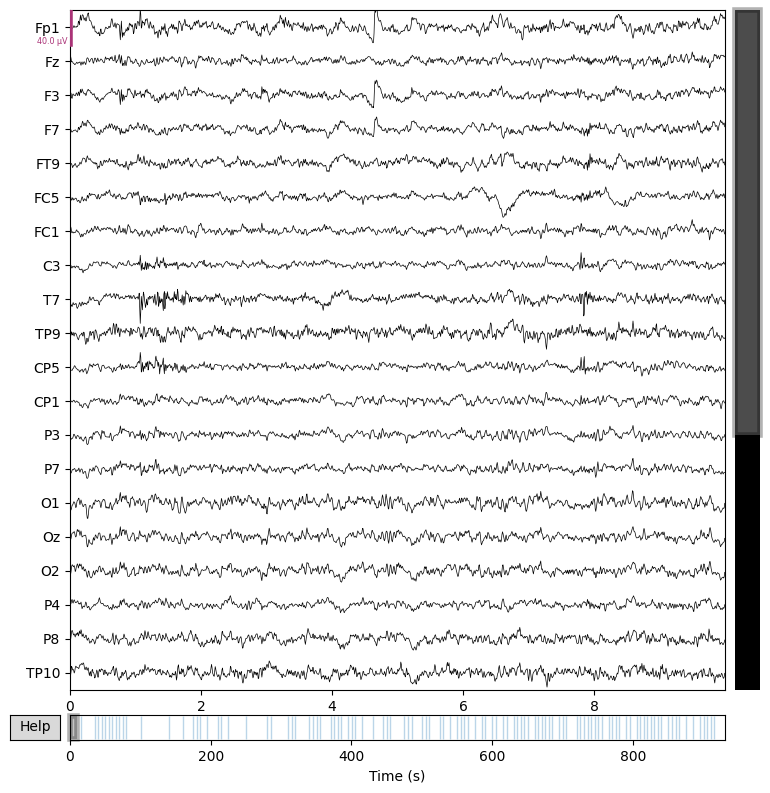

--- session2 (after ICA) ---


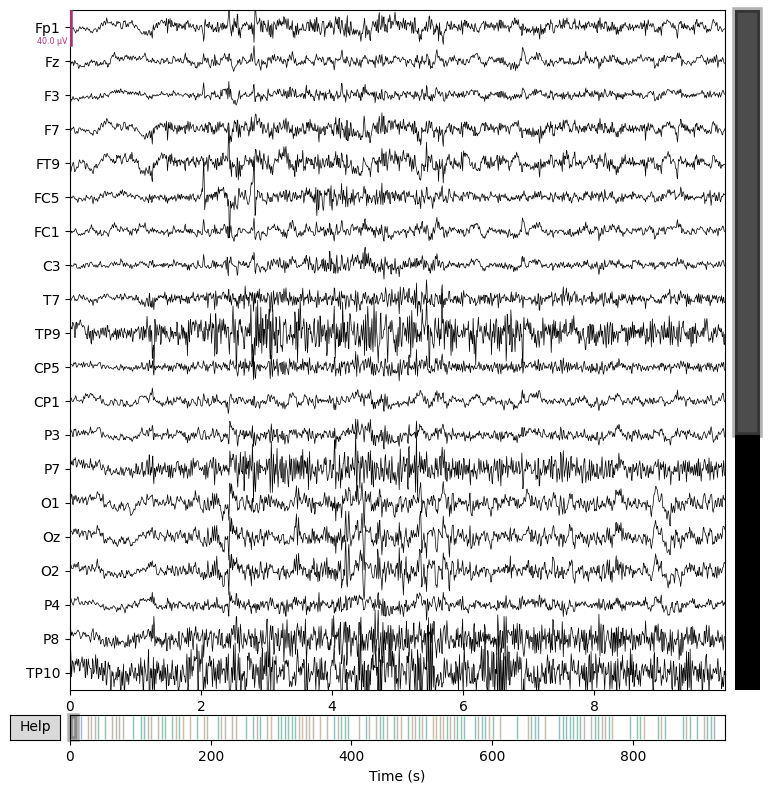

In [43]:
# ICA（セッション区間ごと）
import importlib.util

# --- 依存の自動インストールはしない ---
# ICLabel用（torch か onnxruntime が必要。無ければICLabelによる除外はスキップ）
has_torch = importlib.util.find_spec("torch") is not None
has_onnx = importlib.util.find_spec("onnxruntime") is not None
use_iclabel = has_torch or has_onnx
if not use_iclabel:
    print("[INFO] ICLabel backend (torch/onnxruntime) is unavailable; ICA component rejection will be skipped")

# ICAアルゴリズム（picardが無い場合はfasticaにフォールバック。自動インストールはしない）
ica_method = "picard"
fit_params = dict(extended=True)
if importlib.util.find_spec("picard") is None:
    ica_method = "fastica"
    fit_params = {}
    print("[INFO] picard is unavailable; using ICA method='fastica' instead")
else:
    # ICLabel推奨設定（python-picard想定）
    fit_params = dict(ortho=False, extended=True)

raw_sessions_ica = []
ica_exclude_idxs = []
ica_label_counts = []

labels_to_count = ["brain", "muscle artifact", "eye blink", "heart beat", "line noise", "channel noise", "other"]

for i, r in enumerate(raw_sessions_asr, start=1):
    ica = ICA(n_components=0.999, method=ica_method, fit_params=fit_params)
    ica.fit(r)

    if use_iclabel:
        ic_labels = label_components(r, ica, method="iclabel")
        labels = ic_labels["labels"]
        exclude_idx = [idx for idx, label in enumerate(labels) if label not in ["brain", "other"]]
        count_dict = {label: Counter(labels).get(label, 0) for label in labels_to_count}
    else:
        labels = []
        exclude_idx = []
        count_dict = {label: 0 for label in labels_to_count}

    ica.apply(r, exclude=exclude_idx)

    print(f"session{i} excluding ICA components: {exclude_idx}")
    print(count_dict)

    raw_sessions_ica.append(r)
    ica_exclude_idxs.append(exclude_idx)
    ica_label_counts.append(count_dict)

# session1/2 を両方表示
for i, r in enumerate(raw_sessions_ica, start=1):
    print(f"--- session{i} (after ICA) ---")
    r.plot(duration=10, start=0, scalings={"eeg": 20e-6});

--- session1 before/after ---


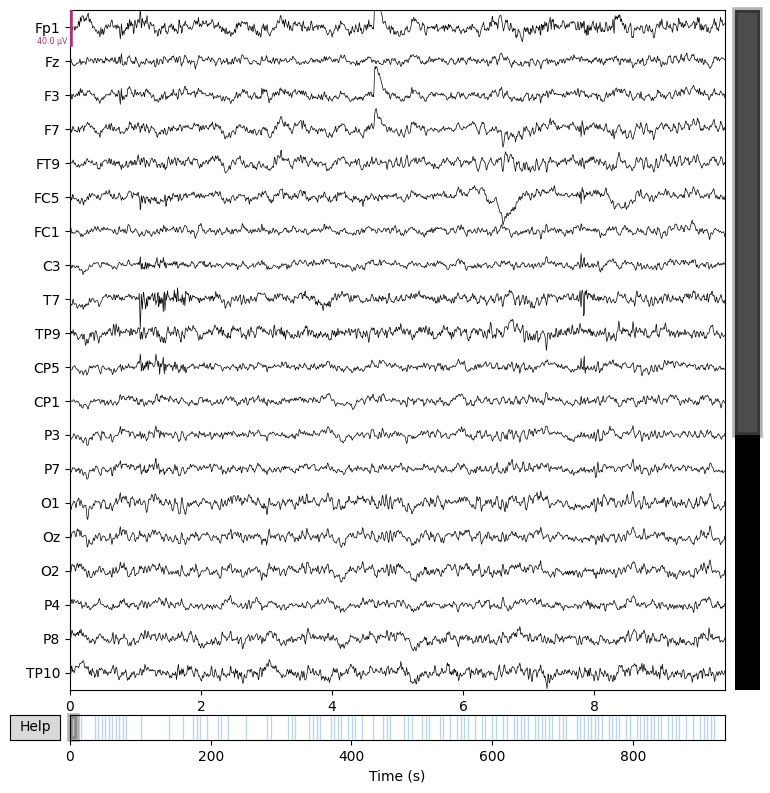

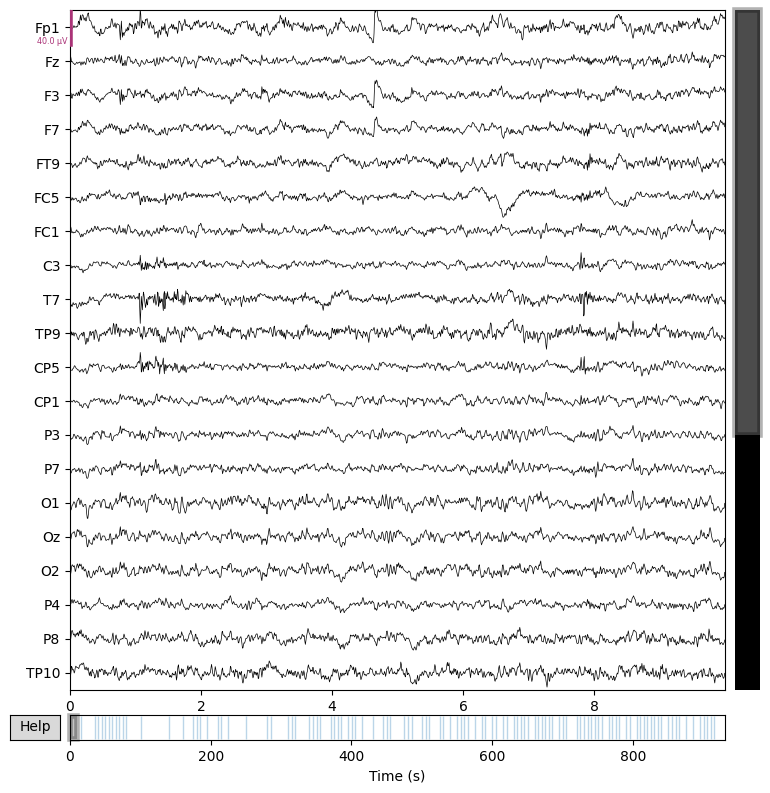

--- session2 before/after ---


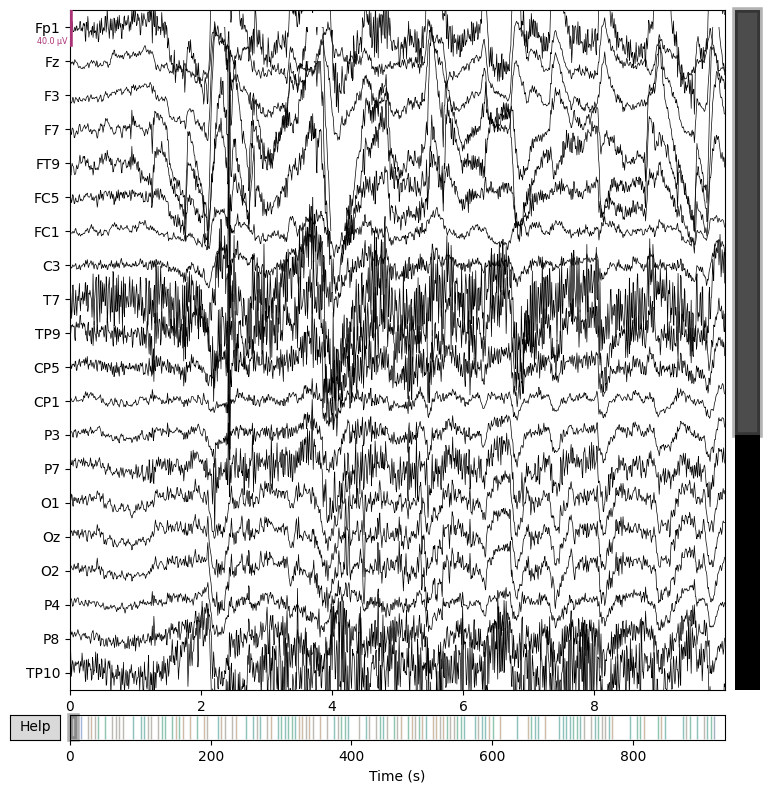

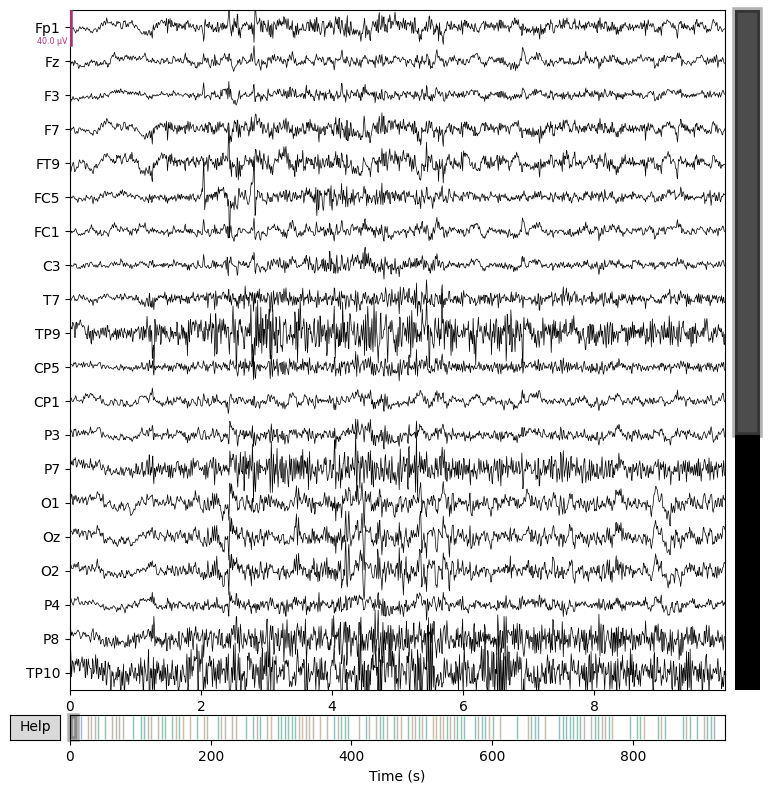

In [44]:
# before/after（session1/2）
for i in range(2):
    print(f"--- session{i+1} before/after ---")
    raw_sessions_origin[i].plot(duration=10, start=0, scalings={"eeg": 20e-6});
    raw_sessions_ica[i].plot(duration=10, start=0, scalings={"eeg": 20e-6});